In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.colors import CenteredNorm, Normalize

## Import the model

In [2]:
from model.tide import TideFrequency
from model.channel_properties import ChannelProperties
from model.tidal_model import TidalModel, tidal_solvers
from model.salt_model import SaltModel, salt_solvers

## Set the sea side boundary

In [3]:
tide = TideFrequency(
    amplitude=1, # m
    phase=0, # rad
    period_h=12.42, # h
)
sea_concentration = 1 # -

## Set the channel properties

In [4]:
sea_channel_properties = ChannelProperties(
    width=200, # m
    height=10, # m
    length=40*1e3, # m
    tidal_averaged_flow=300, # m^3/s
    drag_coefficient=1*1e-2, # [-]
    tidal_velocity_amplitude=1, # m/s
    diffusion_prefactor=0.0125 # [-]
)

side_channel_properties = ChannelProperties(
    width=200, # m
    height=10, # m
    length=50*1e3, # m
    tidal_averaged_flow=0, # m^3/s
    drag_coefficient=1*1e-2, # [-]
    tidal_velocity_amplitude=1, # m/s
    diffusion_prefactor=0.0125 # [-]
)

main_channel_properties = ChannelProperties(
    width=200, # m
    height=10, # m
    length=np.inf, # m
    tidal_averaged_flow=-300, # m^3/s
    drag_coefficient=1*1e-2, # [-]
    tidal_velocity_amplitude=1, # m/s
    diffusion_prefactor=0.0125 # [-]
)

## Solve the tidal model

In [5]:
sea_channel_tidal_model = TidalModel(
    properties=sea_channel_properties,
    tide=tide,
)
side_channel_tidal_model = TidalModel(
    properties=side_channel_properties,
    tide=tide,
)
main_channel_tidal_model = TidalModel(
    properties=main_channel_properties,
    tide=tide,
)

tidal_solvers.multi_channel_tidal_solver(
    sea_channel_tidal_model=sea_channel_tidal_model,
    side_channel_tidal_model=side_channel_tidal_model,
    main_channel_tidal_model=main_channel_tidal_model,
)

## Solve the salt model

In [6]:
delta_x = 100 #m

# Set up the lengths of the channels for the numerical salt model
sea_L = sea_channel_properties.length
side_L = 100 * 1e3 if side_channel_properties.length == np.inf else side_channel_properties.length
main_L = 100 * 1e3 if main_channel_properties.length == np.inf else main_channel_properties.length

sea_m = int(sea_L // delta_x)
side_m = int(side_L // delta_x)
main_m = int(main_L // delta_x)

print(f"sea_m:\t{sea_m}")
print(f"side_m:\t{side_m}")
print(f"main_m:\t{main_m}")

sea_m:	400
side_m:	500
main_m:	1000


In [7]:
sea_salt_model = SaltModel(
    sea_channel_tidal_model,
    num_grid_points=sea_m,
    length=sea_L,
)

Generating blocks...

  0%|          | 0/398 [00:00<?, ?it/s]

[DONE]
Combining blocks...[DONE]


In [8]:
side_salt_model = SaltModel(
    side_channel_tidal_model,
    num_grid_points=side_m,
    length=side_L,
)

Generating blocks...

  0%|          | 0/498 [00:00<?, ?it/s]

[DONE]
Combining blocks...[DONE]


In [9]:
main_salt_model = SaltModel(
    main_channel_tidal_model,
    num_grid_points=main_m,
    length=main_L,
)

Generating blocks...

  0%|          | 0/998 [00:00<?, ?it/s]

[DONE]
Combining blocks...[DONE]


In [10]:
salt_solvers.multi_channel_salt_solver(
    sea_salt_model=sea_salt_model,
    side_salt_model=side_salt_model,
    main_salt_model=main_salt_model,
    sea_concentration=sea_concentration,
)

Matrix shape: (9500, 9500)
b vector shape: (9500,)
Solving...
Solved in 45.23 seconds


## Calculate the solutions

In [11]:
sea_x_series = np.linspace(0, sea_salt_model.length, sea_salt_model.num_grid_points)
side_x_series = np.linspace(0, side_salt_model.length, side_salt_model.num_grid_points)
main_x_series = np.linspace(0, main_salt_model.length, main_salt_model.num_grid_points)

t_series = np.linspace(0, 2*tide.period_h*60*60, 1000)

In [12]:
X_sea, T_sea = np.meshgrid(sea_x_series, t_series)
eta_solution_sea = sea_channel_tidal_model.eta(X_sea, T_sea)
phi_solution_sea = sea_channel_tidal_model.phi(X_sea, T_sea)
salt_solution_sea = sea_salt_model.salt_concentration(sea_salt_model.i_domain(), t_series).transpose()

X_side, T_side = np.meshgrid(side_x_series, t_series)
solution_side = side_channel_tidal_model.eta(X_side, T_side)
phi_solution_side = side_channel_tidal_model.phi(X_side, T_side)
salt_solution_side = side_salt_model.salt_concentration(side_salt_model.i_domain(), t_series).transpose()

X_main, T_main = np.meshgrid(main_x_series, t_series)
solution_main = main_channel_tidal_model.eta(X_main, T_main)
phi_solution_main = main_channel_tidal_model.phi(X_main, T_main)
salt_solution_main = main_salt_model.salt_concentration(main_salt_model.i_domain(), t_series).transpose()

x_domain = (-sea_x_series, side_x_series, main_x_series)
eta_solutions = (eta_solution_sea, solution_side, solution_main)
phi_solutions = (-phi_solution_sea, phi_solution_side, phi_solution_main)
salt_solutions = (salt_solution_sea, salt_solution_side, salt_solution_main)


## Plot the solutions

In [13]:
def plot_channels(x_domains, t_series, solutions, cmap="seismic", cbar_title=""):
    sea_x_series, side_x_series, main_x_series = x_domains
    solution_sea, solution_side, solution_main = solutions
    fig, ax = plt.subplots(
        1,
        3,
        figsize=(15, 10),
        width_ratios=[float(np.ptp(sea_x_series)), float(np.ptp(main_x_series)), float(np.ptp(side_x_series))],
        squeeze=False,
        constrained_layout=True,
    )

    if cmap == "seismic":
        half_range = np.max([np.max(solution_sea), np.max(solution_main), np.max(solution_side), -np.min(solution_sea), -np.min(solution_main), -np.min(solution_side)])
        norm = CenteredNorm(0, half_range)
    else:
        norm = Normalize()

    for i, x_series, t_series, solution, title in [
        (0, sea_x_series, t_series, solution_sea, "Sea Channel"),
        (1, main_x_series, t_series, solution_main, "Main Channel"),
        (2, side_x_series, t_series, solution_side, "Side Channel"),
    ]:
        ax[0, i].set_title(title)
        ax[0, i].set_xlabel("Distance (km)")
        ax[0, i].set_ylabel("Time (h)")
        ax[0, i].contourf(x_series/1e3, t_series/(60*60), solution, levels=100, cmap=cmap, norm=norm)

    plt.colorbar(ax[0, 0].collections[0], ax=ax[0, 2], label=cbar_title)
    plt.show()

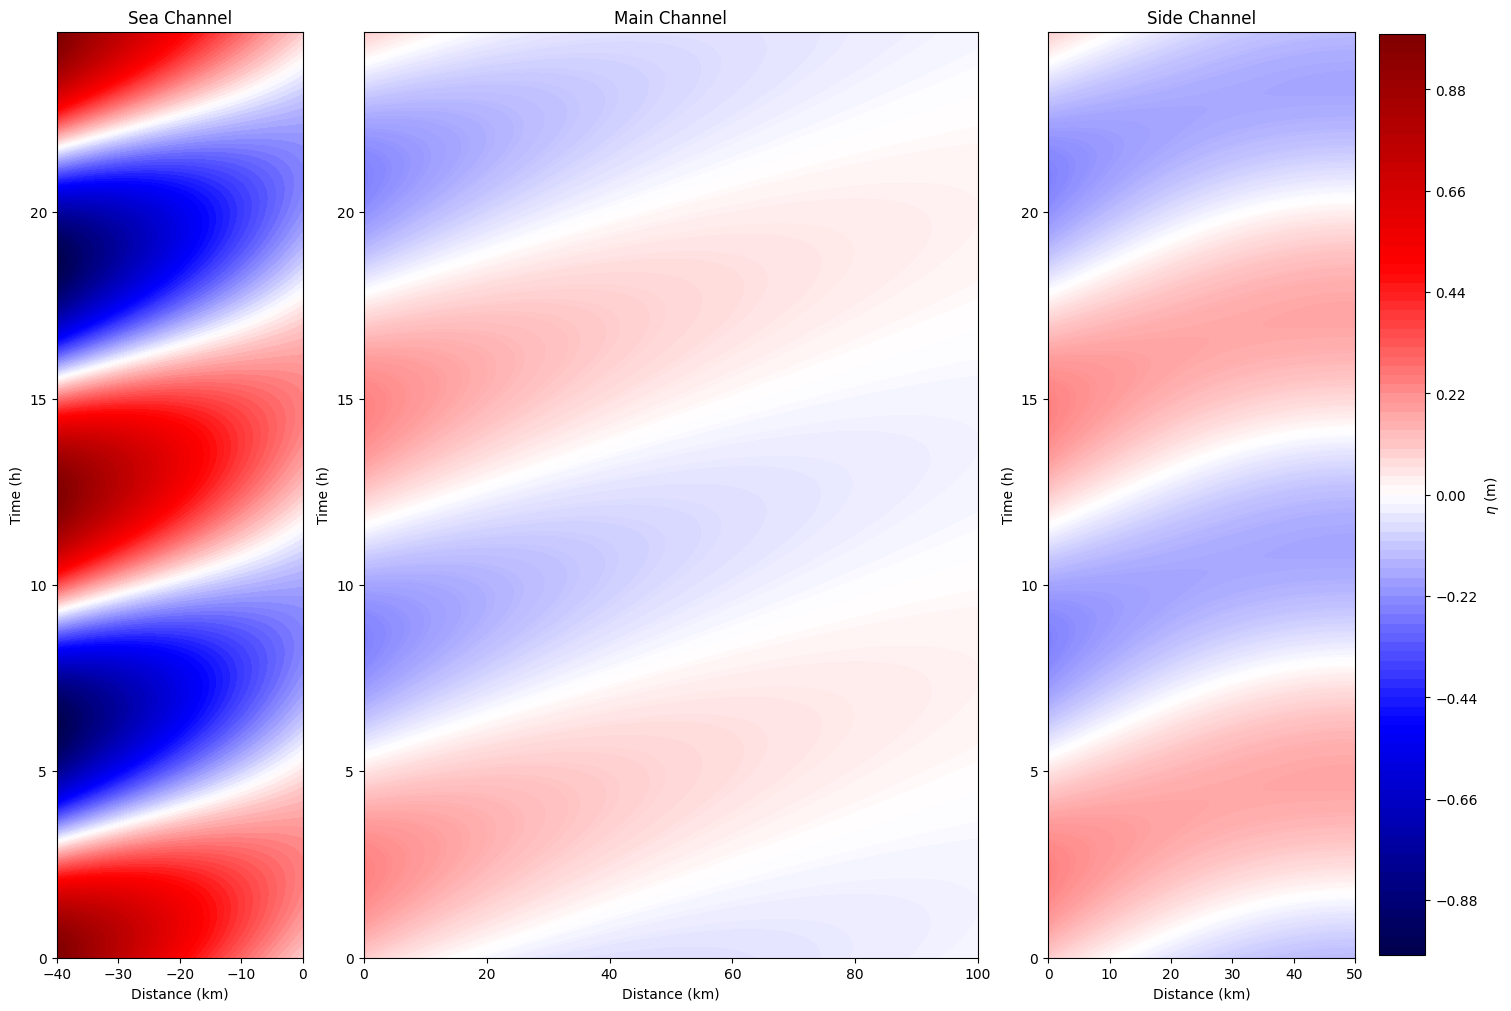

In [14]:
plot_channels(x_domain, t_series, eta_solutions, cbar_title="$\\eta$ (m)")

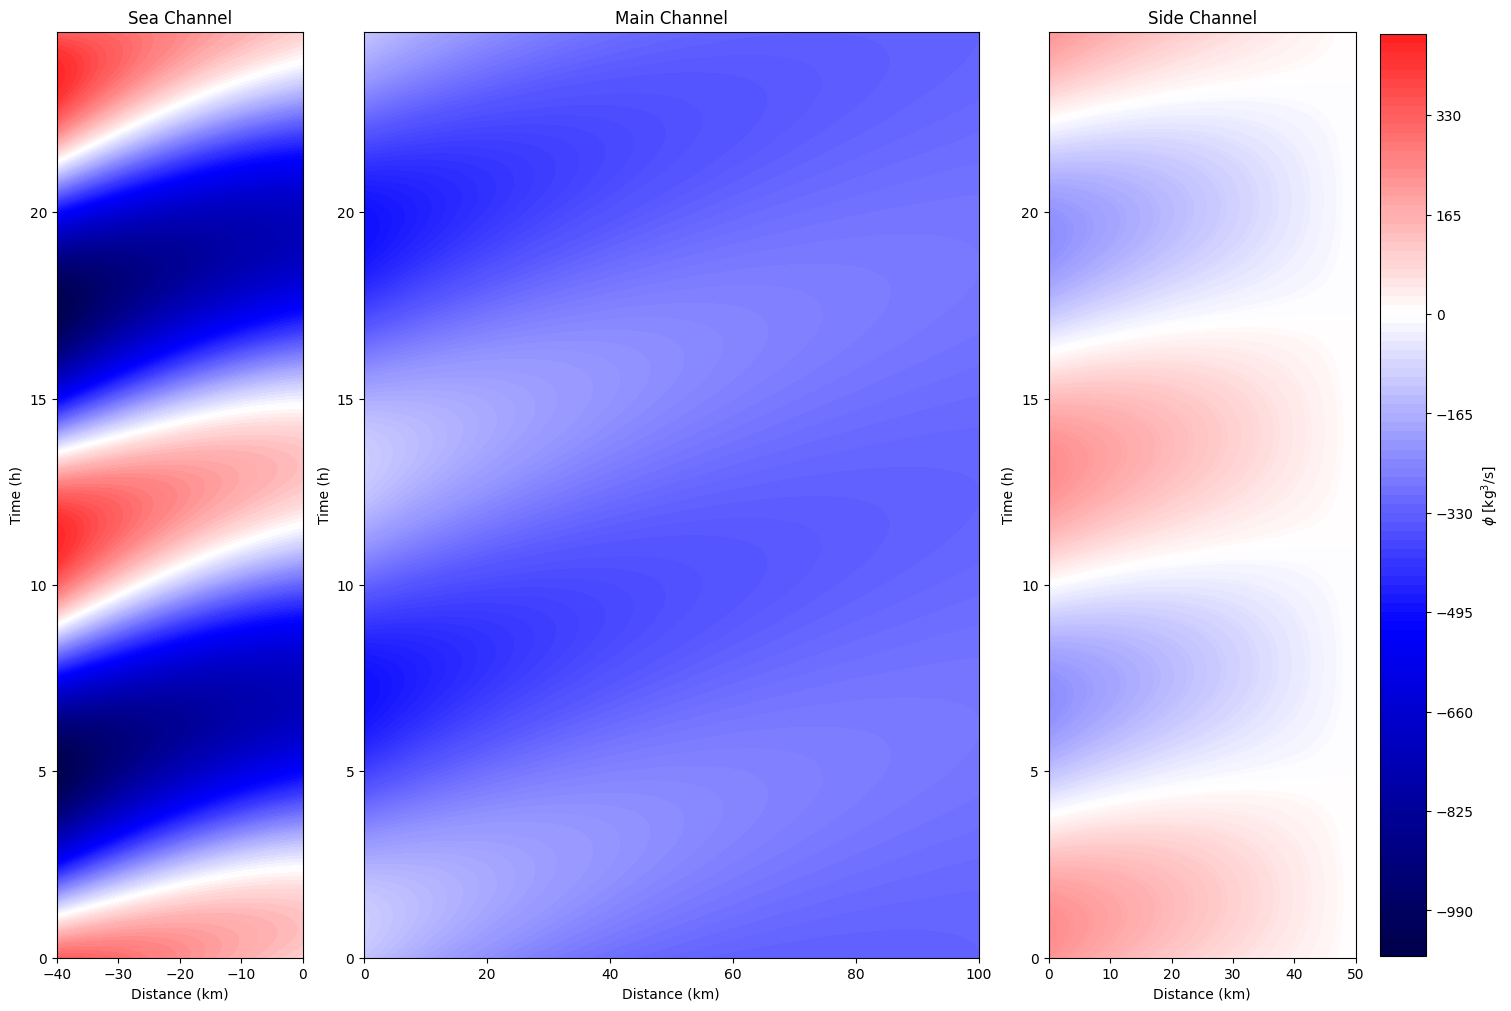

In [15]:
plot_channels(x_domain, t_series, phi_solutions, cbar_title="$\\phi$ [kg$^{3}$/s]")

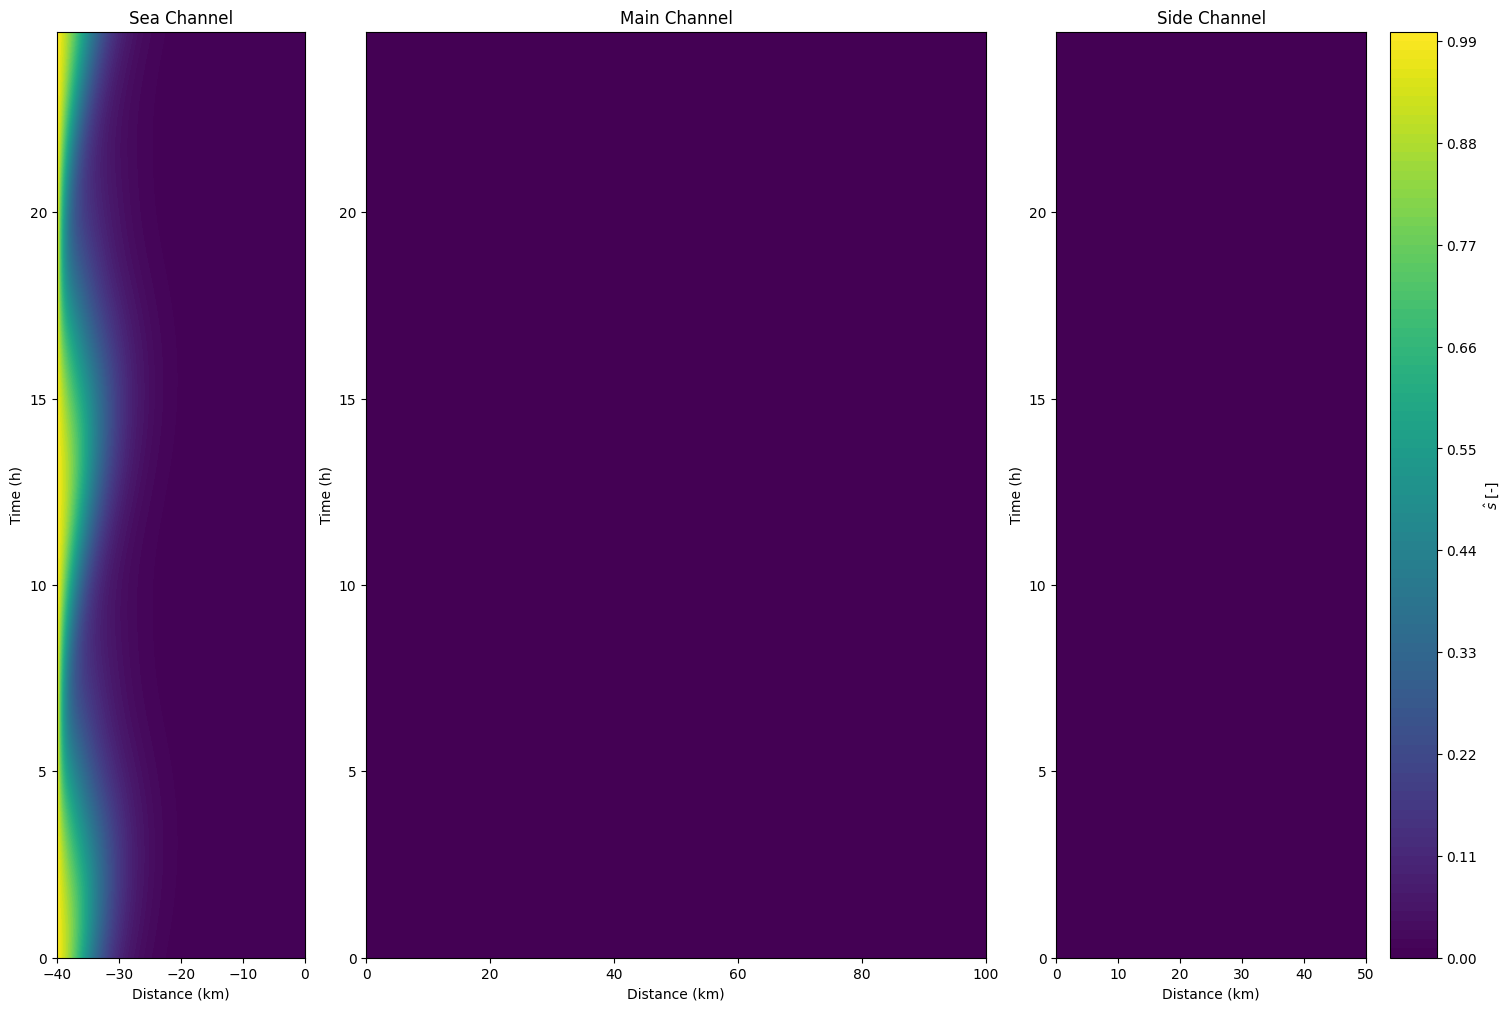

In [16]:
plot_channels(x_domain, t_series, salt_solutions, cmap="viridis", cbar_title="$\\hat{s}$ [-]")